**Submitted by:** Ashashree Sarma


---

## Computer Vision

1. Develop a custom PyTorch dataset class derived from torch.utils.data.Dataset to read
data organized in the following directory structure.

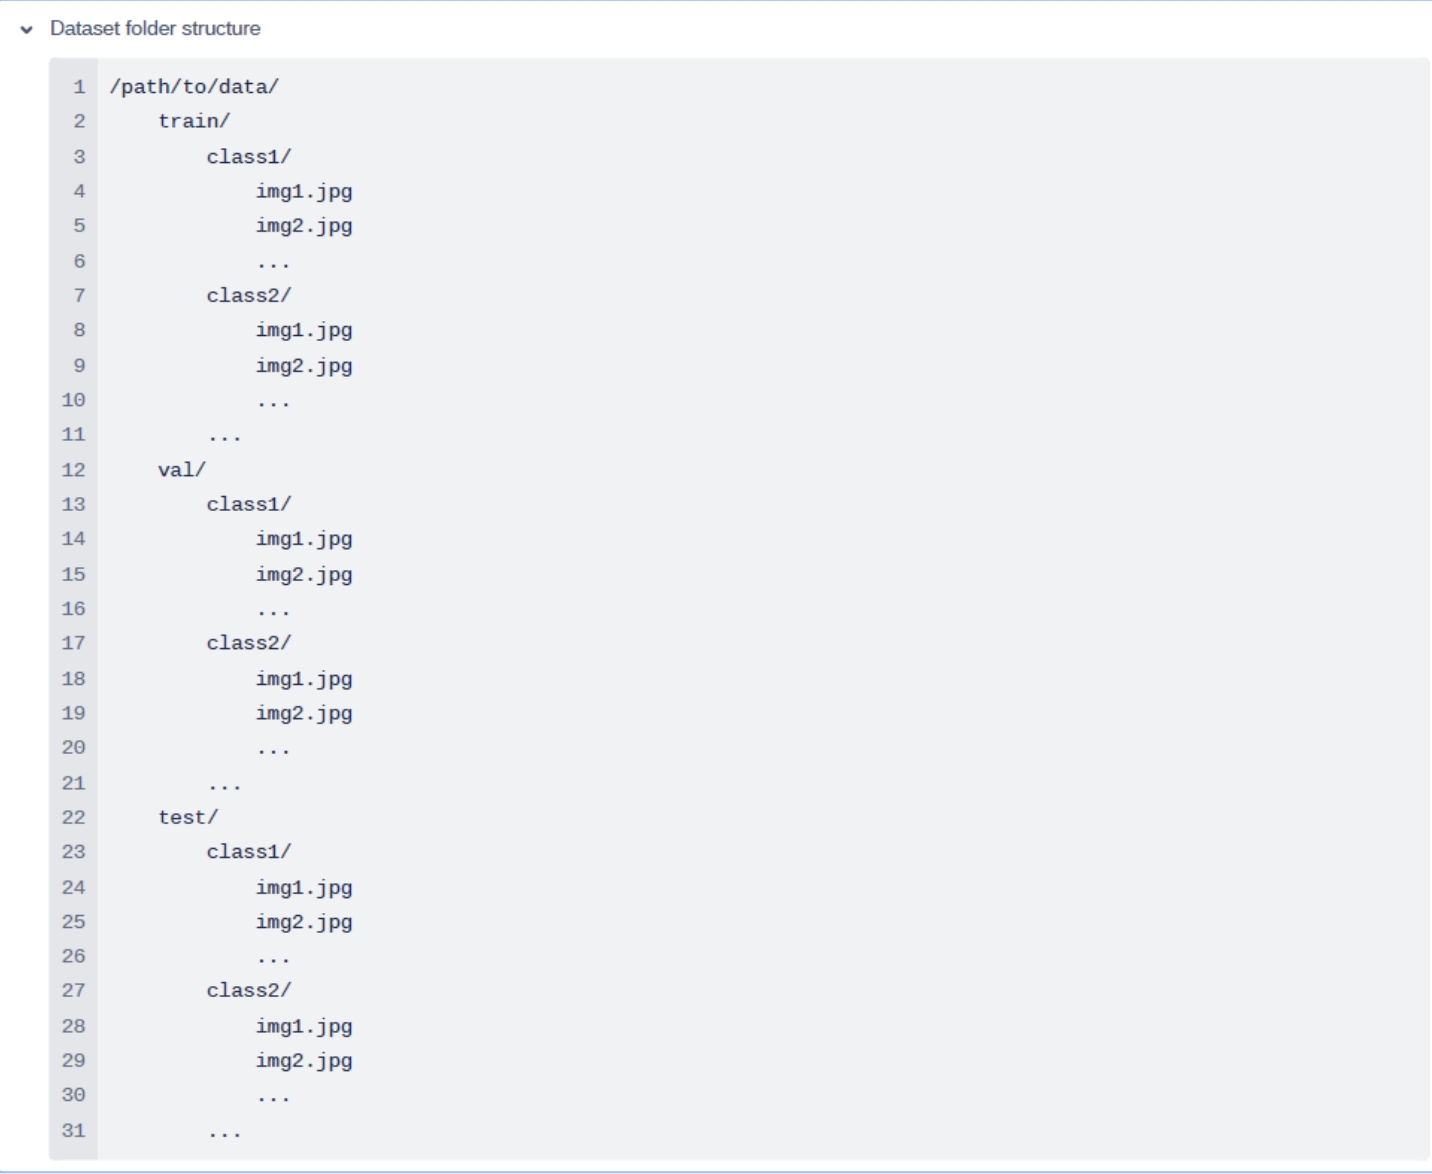



In [145]:
#!pip install torch

In [146]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from google.colab import drive
import time


In [147]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [149]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.classes = sorted(os.listdir(os.path.join(root_dir, mode)))
        self.data = []
        self.allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, mode, class_name)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if os.path.isfile(file_path) and any(file_path.endswith(ext) for ext in self.allowed_extensions):
                    self.data.append((file_path, self.classes.index(class_name)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_path, label = self.data[index]
        image = Image.open(file_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

We use a dog cat classification dataset for this example


In [150]:
drive_dir = '/content/drive/MyDrive/animal'

In [151]:
train_dataset = CustomDataset(drive_dir, mode='train', transform=transform)
val_dataset = CustomDataset(drive_dir, mode='val', transform=transform)
test_dataset = CustomDataset(drive_dir, mode='test', transform=transform)

In [152]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [153]:
def list_files(directory, prefix=''):
    """Recursively list all files and directories in a given directory"""
    output = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        output.append(f"{prefix}{entry}/")
        if os.path.isdir(full_path):
            output.extend(list_files(full_path, prefix=f"{prefix}{entry}/"))
    return output

In [154]:
dataset_dir = drive_dir

In [155]:
print("Directory structure:")
for item in list_files(dataset_dir):
    print(item)

Directory structure:
test/
test/cats/
test/cats/cat.4003.jpg/
test/cats/cat.4013.jpg/
test/cats/cat.4014.jpg/
test/cats/cat.4011.jpg/
test/cats/cat.4006.jpg/
test/cats/cat.4012.jpg/
test/cats/cat.4015.jpg/
test/cats/cat.4016.jpg/
test/cats/cat.4001.jpg/
test/cats/cat.4004.jpg/
test/cats/cat.4008.jpg/
test/cats/cat.4007.jpg/
test/cats/cat.4009.jpg/
test/cats/cat.4010.jpg/
test/cats/cat.4005.jpg/
test/cats/cat.4017.jpg/
test/cats/cat.4002.jpg/
test/dogs/
test/dogs/dog.4012.jpg/
test/dogs/dog.4006.jpg/
test/dogs/dog.4016.jpg/
test/dogs/dog.4003.jpg/
test/dogs/dog.4014.jpg/
test/dogs/dog.4017.jpg/
test/dogs/dog.4011.jpg/
test/dogs/dog.4001.jpg/
test/dogs/dog.4013.jpg/
test/dogs/dog.4002.jpg/
test/dogs/dog.4005.jpg/
test/dogs/dog.4004.jpg/
test/dogs/dog.4009.jpg/
test/dogs/dog.4015.jpg/
test/dogs/dog.4010.jpg/
test/dogs/dog.4007.jpg/
test/dogs/dog.4008.jpg/
train/
train/dogs/
train/dogs/dog.10.jpg/
train/dogs/_DS_Store/
train/dogs/dog.11.jpg/
train/dogs/dog.1.jpg/
train/dogs/dog.2.jpg/
trai

Results : The directory structure is in the desired format


2. Define a simple CNN to classify images using the custom dataset class you developed.

In [156]:
import torch.nn as nn
import torch.nn.functional as F

In [157]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() #we define a simple CNN with two convolutional layers, followed by two fully connected layers.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x): #The forward pass applies the convolutional layers with ReLU activation and max pooling, then flattens the output and passes it through the fully connected layers.
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [158]:
# Initialize the model
model = SimpleCNN()

In [159]:
# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss() #cross-entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [160]:
# Set the number of epochs
num_epochs = 100

In [161]:
model.train()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [163]:


for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch

    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time

    # Print the results for the epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s")



    model.train()  # Set the model back to training mode

Epoch 1, Loss: 1.1790, Train Accuracy: 40.91%, Val Loss: 1.0917, Val Accuracy: 46.15%, Time: 1.66s
Epoch 2, Loss: 0.5767, Train Accuracy: 59.09%, Val Loss: 0.7816, Val Accuracy: 42.31%, Time: 1.63s
Epoch 3, Loss: 0.3754, Train Accuracy: 90.91%, Val Loss: 1.4459, Val Accuracy: 46.15%, Time: 1.70s
Epoch 4, Loss: 0.4235, Train Accuracy: 81.82%, Val Loss: 0.8198, Val Accuracy: 38.46%, Time: 1.65s
Epoch 5, Loss: 0.2639, Train Accuracy: 95.45%, Val Loss: 0.8045, Val Accuracy: 42.31%, Time: 1.60s
Epoch 6, Loss: 0.1684, Train Accuracy: 100.00%, Val Loss: 0.9244, Val Accuracy: 46.15%, Time: 1.80s
Epoch 7, Loss: 0.0886, Train Accuracy: 100.00%, Val Loss: 1.1957, Val Accuracy: 38.46%, Time: 2.07s
Epoch 8, Loss: 0.0404, Train Accuracy: 100.00%, Val Loss: 1.4761, Val Accuracy: 38.46%, Time: 1.90s
Epoch 9, Loss: 0.0173, Train Accuracy: 100.00%, Val Loss: 1.9178, Val Accuracy: 42.31%, Time: 1.57s
Epoch 10, Loss: 0.0093, Train Accuracy: 100.00%, Val Loss: 2.0966, Val Accuracy: 38.46%, Time: 1.62s
Epoc

Inferences :
1. Overfitting: The model appears to be overfitting to the training data.
2. High Training Loss but Low Validation Loss

This was because of the small size of the dataset. We can resolve these issues by performing multiple approaches like - Regularization, Transfer Learning by leveraging pre-trained models on larger datasets or by Changing the Model Architecture

## NLP

**1. Compute the MSE loss and cross-entropy loss for the following data:**


---



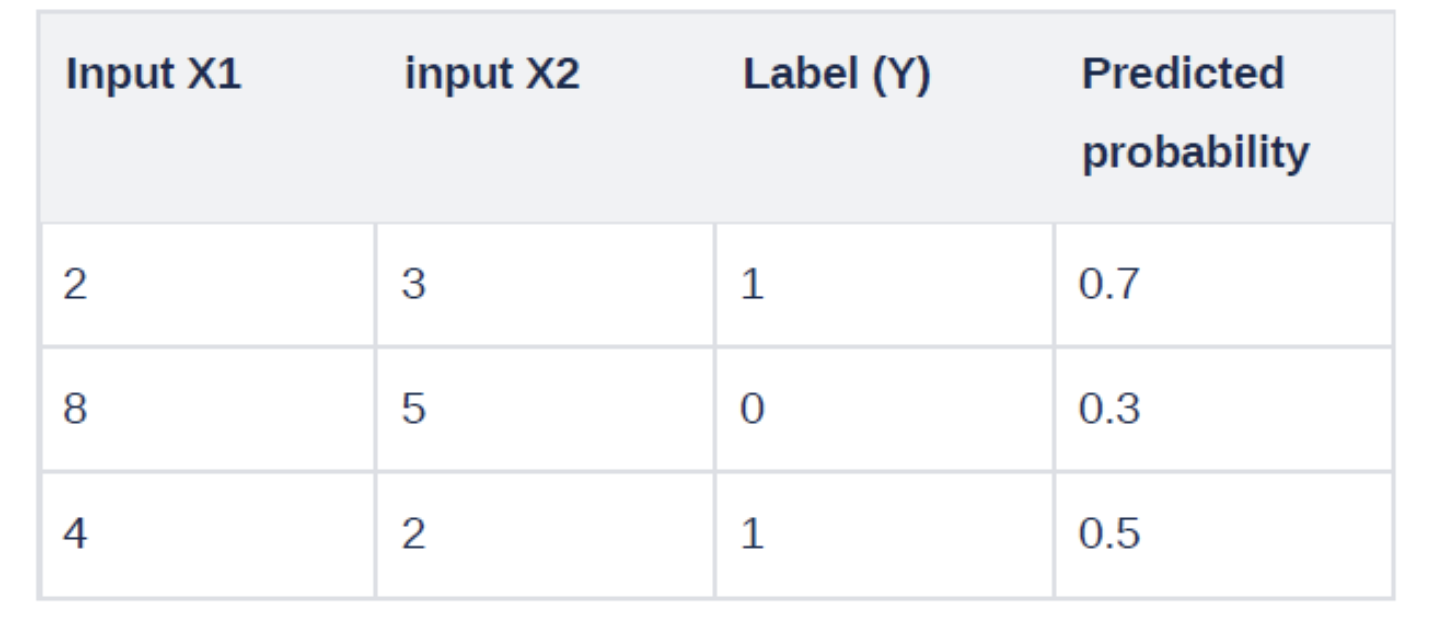

1. **Mean Squared Error (MSE) Loss:**

The Mean Squared Error (MSE) loss is a commonly used loss function for regression tasks, where the goal is to predict a continuous value. It measures the average squared difference between the predicted values and the true values.

The formula for MSE loss is:

MSE = (1 / N) * Σ(y_true - y_pred)^2

N is the number of samples
y_true is the true value
y_pred is the predicted value


2.** Cross-Entropy Loss:**

Cross-Entropy loss is commonly used for classification tasks, where the goal is to predict the probability of an instance belonging to a particular class. It measures the performance of a classification model whose output is a probability value between 0 and 1.

The formula for binary cross-entropy loss is:

Cross-Entropy Loss = -(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

Where:

y_true is the true label (0 or 1)
y_pred is the predicted probability


In [164]:
import numpy as np

# Given data
labels = np.array([1, 0, 1])
predicted_probabilities = np.array([0.7, 0.3, 0.5])

# Compute MSE Loss
mse_loss = np.mean((labels - predicted_probabilities) ** 2)
print(f"MSE Loss: {mse_loss}")

# Compute Cross-Entropy Loss
epsilon = 1e-15  # To avoid log(0)
predicted_probabilities = np.clip(predicted_probabilities, epsilon, 1 - epsilon)
cross_entropy_loss = -np.mean(labels * np.log(predicted_probabilities) + (1 - labels) * np.log(1 - predicted_probabilities))
print(f"Cross-Entropy Loss: {cross_entropy_loss}")

MSE Loss: 0.14333333333333334
Cross-Entropy Loss: 0.46883235614580343


**2. Explain one hot encoding with an example.**

---




One-hot encoding is a widely used technique in machine learning for representing categorical data as numerical input features. It involves creating binary columns for each unique category in the original categorical feature. For each row, the column corresponding to the category present in that row is assigned a value of 1, while all other columns are assigned a value of 0.

This encoding strategy allows categorical data to be directly used as input for machine learning algorithms that expect numerical data, enabling them to capture the relationships between categories and the target variable effectively.

One-hot encoding is particularly beneficial when dealing with classification or prediction tasks involving categorical features, as it ensures that the algorithm can appropriately process and learn from the categorical information.




For example, consider a dataset containing information about different types of fruits. Let's assume the dataset has a categorical feature called 'fruit' with three possible values: 'apple', 'banana', and 'orange'.


Without one-hot encoding, the 'fruit' column might look like this:


In [ ]:
fruit
apple
banana
orange
apple
banana

To perform one-hot encoding on the 'fruit' column, we create a new binary column for each unique category in the original column.
Each row in the new columns will have a 1 in the column corresponding to the category present in that row, and 0 in all other columns.


The resulting one-hot encoded data would look like this:

In [ ]:
fruit   apple   banana   orange
apple   1       0        0
banana  0       1        0
orange  0       0        1
apple   1       0        0
banana  0       1        0

In the one-hot encoded representation, each row is now represented by a binary vector, with the position of the 1 indicating the category for that row.

 It is a common preprocessing step in many machine learning pipelines, especially for tasks such as classification or prediction tasks involving categorical features.

Here's an example of creating a dummy DataFrame and applying one-hot encoding to it using Python's pandas library:

In [167]:
import pandas as pd

# Create a dummy DataFrame
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve'],
    'City': ['New York', 'London', 'Paris', 'New York', 'Tokyo'],
    'Gender': ['Female', 'Male', 'Male', 'Male', 'Female']
}

df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)


Original DataFrame:
      Name      City  Gender
0    Alice  New York  Female
1      Bob    London    Male
2  Charlie     Paris    Male
3    David  New York    Male
4      Eve     Tokyo  Female


Now, let's apply one-hot encoding to the 'City' and 'Gender' columns using the pd.get_dummies() function:

In [169]:
encoded_df = pd.get_dummies(df, columns=['City', 'Gender'])

In [170]:
encoded_df = encoded_df.astype({'City_London': int, 'City_New York': int, 'City_Paris': int, 'City_Tokyo': int, 'Gender_Female': int, 'Gender_Male': int})

print("\nOne-Hot Encoded DataFrame:")
print(encoded_df)


One-Hot Encoded DataFrame:
      Name  City_London  City_New York  City_Paris  City_Tokyo  Gender_Female  \
0    Alice            0              1           0           0              1   
1      Bob            1              0           0           0              0   
2  Charlie            0              0           1           0              0   
3    David            0              1           0           0              0   
4      Eve            0              0           0           1              1   

   Gender_Male  
0            0  
1            1  
2            1  
3            1  
4            0  


The categorical columns 'City' and 'Gender' have been replaced with binary columns representing each unique category.

The 'City' column has been replaced with four columns: 'City_London', 'City_New York', 'City_Paris', and 'City_Tokyo', where a value of 1 indicates the presence of that city, and 0 indicates its absence.

Similarly, the 'Gender' column has been replaced with 'Gender_Female' and 'Gender_Male' columns, representing the binary encoding of the gender categories.